**Notebook preparation and importing libraries**

In [1]:
from pathlib import Path
import pandas as pd
from hvac import Quantity
from hvac.fluids import Fluid, CoolPropWarning
from hvac.vapor_compression import FixedSpeedCompressor, VariableSpeedCompressor
from hvac.charts.log_ph_diagram import StandardVaporCompressionCycle, LogPhDiagram

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=CoolPropWarning)

In [3]:
Q_ = Quantity

# Compressor Simulation

To select a suitable compressor for a vapor compression machine, compressor manufacturers offer selection software. This selection software suggests to the user one or more compressor models based on the user's input, such as the kind of refrigerant, the required cooling or heating capacity at design conditions, the evaporation and condensation temperature aimed at under design conditions, the target degree of superheat at the evaporator exit and along the suction line, the target degree of subcooling at the condenser exit, ... 

The selection program also presents tables and diagrams showing compressor performance under a variety of operating conditions, which are mainly characterized by evaporation and condensation temperature, whereby the degree of superheat and subcooling remain fixed. In addition to tables and diagrams most selection programs these days also offer extensive sets of coefficients that can be used in polynomial equations that mathematically describe the compressor performance characteristics, such as mass flow rate, cooling capacity, compressor power, etc. as function of evaporation and condensing temperature, and, in the case of variable speed compressors, also as function of compressor speed. With these polynomials it is possible to simulate the performance of a given compressor under varying working conditions.

The polynomial coefficients can be exported from the selection program to a spreadsheet or comma-separated-values (csv) file. For each performance parameter a different set of coefficients is valid. Two classes have been written to model a real compressor based on the equations offered by compressor manufacturers. One class applies to compressors with fixed speed, while the other class applies to compressors equipped with a variable speed drive. 

The variables in the equations of a fixed speed compressor are evaporation and condensation temperature only. The equations of a variable speed compressor also contain compressor speed as a third variable. 

A fixed speed compressor is modeled by the class `FixedSpeedCompressor`. A variable speed compressor is modeled by the class `VariableSpeedCompressor`.

In order to use these two classes, the coefficients of all performance parameters must be collected in a file that these classes can recognize. Therefore, the coefficients must be ordered in a table-like structure stored on disk with the csv file extension (\*.csv). Examples can be found in the folder *compressor_data*. The code block below will open a csv-file with the coefficients of one of the available compressor models, and it will print the table on screen:

In [4]:
data_folder = Path("./compressor_data")
file = data_folder / "DSF175-4.csv"

table = pd.read_csv(file)

with pd.option_context('display.max_columns', None, 'display.width', 300):
    print(table)

  Unnamed: 0          C0         C1        C2        C3        C4        C5        C6        C7        C8        C9
0     Qc_dot   56.016601   1.803612 -0.554236  0.025915 -0.011224  0.007159  0.000209 -0.000187  0.000011 -0.000080
1     Wc_dot    3.143491  -0.088970  0.101522 -0.002829  0.001146  0.001204 -0.000023  0.000020  0.000013  0.000007
2          I   11.938221  -0.042187  0.023455 -0.002219 -0.001535  0.002772 -0.000025 -0.000004  0.000047  0.000009
3      m_dot  594.012615  18.390119 -4.025634  0.270240 -0.032978  0.110358  0.002695 -0.000832  0.000377 -0.001215


The coefficients of four performance quantities are given in the file:
- the cooling capacity `Qc_dot`
- the mechanical compressor power `Wc_dot`
- the drawn compressor current `I`
- the mass flow rate of refrigerant `m_dot`

There is still a fifth quantity possible, being the discharge temperature `T_dis`.

It is required that these exact structure and symbolic notations are used in order for the program to work.

The polynomials describing each of the performance parameters in the example count 10 coefficients (C0...C9), which is the case for a fixed speed compressor. In case of a variable speed compressor the number of coefficients may be 20 (C0...C19) or 30 (C0...C29).

## Example of a Fixed Speed Compressor

A fixed speed compressor is represented by the `FixedSpeedCompressor` class. To instantiate this class, we need to specify the path to the csv-file, the degree of superheat and the degree of subcooling for which the polynomial coefficients are valid, and the type of refrigerant:

In [5]:
fixed_speed_compressor = FixedSpeedCompressor(
    coeff_file=data_folder / "ZR144KCE-TFD.csv",
    dT_sh=Q_(10, 'K'),  # degree of superheat
    dT_sc=Q_(0, 'K'),   # degree of subcooling
    refrigerant_type=Fluid('R22')
)

> **Important Note**<br>
> It might be necessary that the default units inside the `FixedSpeedCompressor` class have to be adapted to units that are used by the compressor manufacturer to quantify the performance quantities.The dictionary `units` of class `FixedSpeedCompressor` has the following keys: 
> - `'Qc_dot'` for cooling capacity with default unit 'kW'
> - `'Wc_dot'` for compressor power with default unit 'kW'
> - `'m_dot'` for mass flow rate with default unit 'g/s'
> - `'speed'` for compressor speed with default unit '1/min'.
>
> To change the units, you can pass a dictionary to the optional parameter `units` of the constructor of the `FixedSpeedCompressor` class.<br>
E.g. `{'m_dot': 'kg / hr'}`.

After instantiation we set the evaporation and condensation temperature:

In [6]:
fixed_speed_compressor.Te = Q_(5.0, 'degC')   # evaporator temperature
fixed_speed_compressor.Tc = Q_(50, 'degC')    # condenser temperature

Now we can retrieve the performance quantities of the compressor for these operating conditions:

In [7]:
print(
    f"cooling capacity `Qc_dot` = {fixed_speed_compressor.Qc_dot.to('kW'):~P.2f}\n"
    f"compressor power `Wc_dot` = {fixed_speed_compressor.Wc_dot.to('kW'):~P.2f}\n"
    f"isentropic efficiency `eta_is` = {fixed_speed_compressor.eta_is.to('pct'):~P.2f}\n"
    f"refrigerant mass flow rate `m_dot` = {fixed_speed_compressor.m_dot.to('g/s'):~P.2f}\n"
    f"heat rejection rate `Qh_dot` = {fixed_speed_compressor.Qh_dot.to('kW'):~P.2f}\n"
    f"COP = {fixed_speed_compressor.COP.to('frac'):~P.2f}"
)

cooling capacity `Qc_dot` = 32.02 kW
compressor power `Wc_dot` = 9.14 kW
isentropic efficiency `eta_is` = 73.23 %
refrigerant mass flow rate `m_dot` = 211.08 g/s
heat rejection rate `Qh_dot` = 41.16 kW
COP = 3.50 frac


Also the refrigerant states at the in- and outlet of the evaporator and condenser can be retrieved based on a *standard vapor compression cycle* (i.e. an idealized cycle whereby any pressure loss in the evaporator, the condenser, the liquid line, the suction line, or the discharge line is ignored).

In [8]:
with pd.option_context('display.max_columns', None, 'display.width', 300):
    print(fixed_speed_compressor.get_refrigerant_cycle())

                    T [degC]    P [bar]  rho [kg / m**3]  h [kJ / kg]  s [kJ / kg / K]
evaporator inlet    5.000000   5.841087        82.808580   263.245111         1.227325
evaporator outlet  15.000000   5.841087        23.510725   414.377603         1.770200
condenser inlet    92.036116  19.426884        65.590656   457.680998         1.802519
condenser outlet   50.000000  19.426884      1082.301952   263.245111         1.208032


You can alter the units of the state properties in the table. For this call `get_refrigeration_cycle` with a dictionary having the following keys along with the corresponding desired unit: `'T'` for temperature, `'P'` for pressure, `'rho'` for mass density, `'h'` for enthalpy, and `'s'` for entropy.

**Log\(P\)-h Diagram**

We can now draw the log\(P\)-h diagram of this vapor compression cycle:

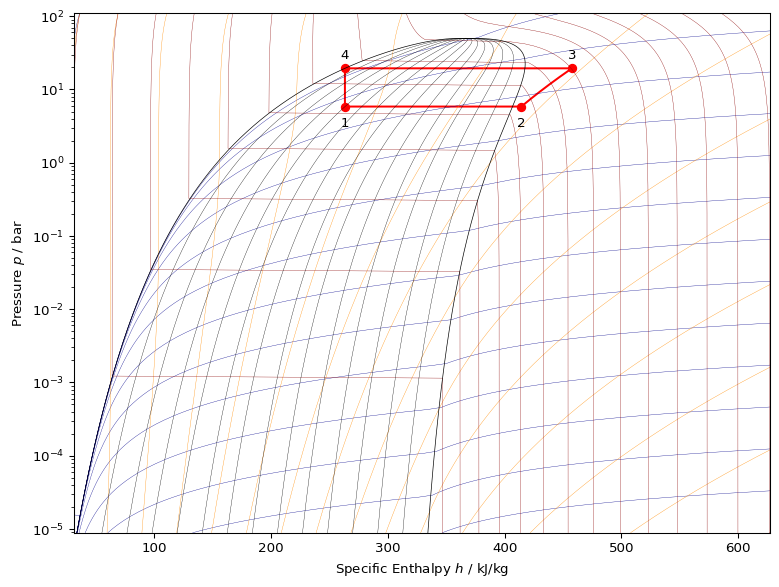

In [9]:
vc_cycle = StandardVaporCompressionCycle(
    Refrigerant=fixed_speed_compressor.refrigerant_type,
    evaporationTemperature=fixed_speed_compressor.Te,
    condensationTemperature=fixed_speed_compressor.Tc,
    evaporatorSuperheat=fixed_speed_compressor.dT_sh,
    subCooling=fixed_speed_compressor.dT_sc,
    suctionLineSuperheat=None,
    isentropicEfficiency=fixed_speed_compressor.eta_is
)

log_ph_diagram = LogPhDiagram(fixed_speed_compressor.refrigerant_type, size=(8, 6), dpi=96)
log_ph_diagram.setCycle(vc_cycle)
log_ph_diagram.show()

## Example of a Variable Speed Compressor

The procedure for a variable speed compressor is more or less identical to the fixed speed compressor. The following example is for a variable speed compressor working with refrigerant R454B. This refrigerant -a mixture of 68.9 w-% R32 and 31.1 w-% R1234yf- is not directly available in CoolProp, but we can define the mixture as shown below. The polynomial coefficients from the compressor manufacturer expect that speed will be expressed in units of revs per second (1/s) and refrigerant mass flow rate in units of kilogram per hour (kg/hr). The coefficients were taken from the selection software at a superheat degree of 10 K and a subcooling degree of 5 K.

In [10]:
variable_speed_compressor = VariableSpeedCompressor(
    coeff_file=data_folder / "VZH088CGM.csv",
    dT_sh=Q_(10, 'K'),
    dT_sc=Q_(5, 'K'),
    refrigerant_type=Fluid('R32&R1234yf', mass_fractions=[Q_(0.689, 'frac'), Q_(0.311, 'frac')]),
    units={'speed': '1 / s', 'm_dot': 'kg / hr'}
)

The compressor's documentation states that the frequency range of the variable speed drive is from 25 Hz to 100 Hz, which corresponds with a speed range of 1500 to 6000 revs/min. The compressor was selected with an evaporation temperature of -7 °C and a condensation temperature of 35 °C. The required heating capacity at these design conditions are met at a rotational speed of 5618 revs/min.

In [11]:
variable_speed_compressor.Te = Q_(-7, 'degC')
variable_speed_compressor.Tc = Q_(35, 'degC')
variable_speed_compressor.speed = Q_(5618, '1/min')

In [12]:
print(
    f"Qc_dot = {variable_speed_compressor.Qc_dot.to('kW'):~P.2f}\n"
    f"Wc_dot = {variable_speed_compressor.Wc_dot.to('kW'):~P.2f}\n"
    f"eta_is = {variable_speed_compressor.eta_is.to('pct'):~P.2f}\n"
    f"m_dot = {variable_speed_compressor.m_dot.to('g/s'):~P.2f}\n"
    f"Qh_dot = {variable_speed_compressor.Qh_dot.to('kW'):~P.2f}\n"
    f"COP = {variable_speed_compressor.COP.to('frac'):~P.2f}"
)

Qc_dot = 29.99 kW
Wc_dot = 9.40 kW
eta_is = 63.84 %
m_dot = 136.21 g/s
Qh_dot = 39.39 kW
COP = 3.19 frac


As with the `FixedSpeedCompressor` class, the magnitude of the state properties at the 4 corner points of the cycle can be requested:

In [13]:
with pd.option_context('display.max_columns', None, 'display.width', 300):
    print(variable_speed_compressor.get_refrigerant_cycle())

                    T [degC]    P [bar]  rho [kg / m**3]  h [kJ / kg]  s [kJ / kg / K]
evaporator inlet   -8.060569   5.793054        75.612504   257.826475         1.270458
evaporator outlet   3.000000   5.793054        17.786724   475.621634         2.089849
condenser inlet    91.869758  20.310615        48.747911   544.631606         2.160290
condenser outlet   30.000000  20.310615       964.684346   257.826475         1.249226


> **Note**<br>
> Although the evaporation temperature was set -7 °C, it can be noticed that according to CoolProp's calculations the refrigerant temperature at the evaporator inlet is around -8 °C. The evaporation pressure is determined internally at the given evaporation temperature (-7 °C) and for saturated vapor ($x$ = 100 %). The enthalpy of the refrigerant at the evaporator inlet (a mixture of saturated liquid and vapor) equals the enthalpy of the subcooled liquid refrigerant at the condenser outlet, since the expansion process is considered to be isenthalpic. Based on the evaporation pressure and the enthalpy, the refrigerant temperature at the evaporator inlet is then calculated by CoolProp to be around -8 °C, instead of -7 °C.

**Log\(P\)-h Diagram**

For refrigerant mixtures drawing a log\(P\)-h diagram throws an exception from inside CoolProp's internal code (version 6.4.1). At the time of writing this notebook, no solution was found to overcome this error.

**Minimum and Maximum Cooling Capacity at given Evaporation and Condensation Temperature**

In [14]:
variable_speed_compressor.speed = Q_(1500, '1 / min')
print(f"cooling capacity at minimum speed: {variable_speed_compressor.Qc_dot.to('kW'):~P.2f}")

cooling capacity at minimum speed: 7.42 kW


In [15]:
variable_speed_compressor.speed = Q_(6000, '1 / min')
print(f"cooling capacity at minimum speed: {variable_speed_compressor.Qc_dot.to('kW'):~P.2f}")

cooling capacity at minimum speed: 32.01 kW


**Find Compressor Speed for given Cooling Capacity at given Evaporation and Condensation Temperature**

In [16]:
Qc_dot = Q_(10.0, 'kW')
rpm = variable_speed_compressor.get_compressor_speed(Qc_dot)
print(f"cooling capacity {Qc_dot:~P.2f} @ {rpm.to('1 / min'):~P.1f}")

cooling capacity 10.00 kW @ 1957.0 1/min
